<h1 style="font-size:40px;"><center>Exercise II:<br> Convolutional Neural Networks
</center></h1>

## Short summary
In this exercise, we will design a CNN to classify rgb images. These folder has **three files**: 
- **configClassifier.py:** this involves definitions of all parameters and data paths
- **utilsClassifier.py:** includes utility functions required to grab and visualize data 
- **runClassifier.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a CNN model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution |
| 5 | Ex | Exercise 2 | Data augementation |
| 6 | Data | Needed | Generating the data batches |
| 7 | Debug | Needed | Debugging the data |
| 8 | Device | Needed | Selecting CPU/GPU |
| 9 | Optimization | Exercise 2 | Selecting an optimization method |
| 10 | Training | Exercise 1-2-3 | Training the model   |
| 11 | Testing | Exercise 1-2-3| Testing the  method   |
| 12 | Confusion matrix | Information | Plotting the confusion matrix|
| 13 | Plotting | Information  | View some of test samples |
| 13 | Plotting | Information  | View layer activations|


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

1) We first start with importing all required modules

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
from tensorflow import keras 
from configClassifier import *
from utilsClassifier import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard


#tf.test.gpu_device_name()

2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [12]:
class ClassifierDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        # super(MyModel, self).__init__(name='my_model')
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def create_model(self):
        model = Sequential()

        chanDim = -1
        # CONV => RELU => POOL
        model.add(Conv2D(25, (3, 3), padding="same",
                         input_shape=self.inputShape))
        #model.add(BatchNormalization(1))
        model.add(Activation("relu"))
        #model.add(Dropout(self.dropout_prob))
        model.add(MaxPooling2D(pool_size=(3, 3)))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(50, (3, 3), padding="same"))
        model.add(BatchNormalization(1))
        model.add(Activation("relu"))
        model.add(Dropout(self.dropout_prob))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(100, (3, 3), padding="same"))
        model.add(BatchNormalization(1))
        model.add(Activation("relu"))
        model.add(Dropout(self.dropout_prob))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(200, (3, 3), padding="same"))
        model.add(BatchNormalization(1))
        model.add(Activation("relu"))
        model.add(Dropout(self.dropout_prob))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(2048))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(self.num_classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

    def display_activation(self, activations, col_size, row_size, act_index):
        activation = activations[act_index]
        activation_index = 0
        fig, ax = plt.subplots(row_size, col_size, figsize=(row_size * 2.5, col_size * 1.5))
        fig.suptitle("activations in layer " + str(act_index+1))

        for row in range(0, row_size):
            for col in range(0, col_size):
                ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
                activation_index += 1
        plt.show()

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**

In [13]:
cfg = flying_objects_config()
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = ClassifierDNNModel(num_classes=len(cfg.CLASSES), batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()
print(cfg)

{'training_data_dir': '../data/FlyingObjectDataset_10K/training', 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation', 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing', 'fineGrained': False, 'CLASSES': ['square', 'triangle', 'circular'], 'NUM_CLASS': 3, 'GPU': 0, 'DROPOUT_PROB': 0.5, 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_CHANNEL': 3, 'NUM_EPOCHS': 10, 'BATCH_SIZE': 32, 'LEARNING_RATE': 0.001, 'LR_DECAY_FACTOR': 0.1, 'PRINT_EVERY': 20, 'SAVE_EVERY': 1, 'DEBUG_MODE': True, 'DATA_AUGMENTATION': True}


4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [14]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class triangle 	 3703 images
class square 	 3488 images
class circular 	 3626 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class circular 	 713 images
class square 	 783 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We **augment** the data by flipping the image horizontally or vertically. As described in the exercises section below, one of your tasks is to update this data augmentation part in order to increase the network efficiency.

In [15]:
# setup data
if cfg.DATA_AUGMENTATION:
    print("Data is being augmented!")
    aug_parameters = ImageDataGenerator(
        # zoom_range=0.2, # randomly zoom into images
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
else:
    print("Data will not be augmented!")
    aug_parameters = ImageDataGenerator(
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


Data is being augmented!


6) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [16]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_classification_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE, cfg.CLASSES, fineGrained=cfg.fineGrained)
valid_batch_generator = generate_classification_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE, cfg.CLASSES, fineGrained=cfg.fineGrained)
test_batch_generator = generate_classification_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE, cfg.CLASSES, fineGrained=cfg.fineGrained)
aug_train_batch_generator = generate_augmented_classification_batches(train_batch_generator, aug_parameters)
aug_valid_batch_generator = generate_augmented_classification_batches(valid_batch_generator, aug_parameters)
print("Data batch generators are created!")

Data batch generators are created!


7) We can visualize how the data looks like for debugging purpose

In [17]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
    a_x, a_y = next(aug_train_batch_generator)
    print('x', a_x.shape, a_x.dtype, a_x.min(), a_x.max())
    print('y', a_y.shape, a_y.dtype, a_y.min(), a_y.max())

x (32, 128, 128, 3) float64 0.0 1.0
y (32, 3) float32 0.0 1.0
x (32, 128, 128, 3) float32 0.0 1.0
y (32, 3) float32 0.0 1.0


8) We select which processing unit to use, either CPU or GPU. In case of having multiple GPUs, we can still select which GPU to use.

In [18]:
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

creating network model using gpu 0


9) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [19]:
opt = tf.optimizers.Adam(cfg.LEARNING_RATE)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 25)      700       
_________________________________________________________________
activation_4 (Activation)    (None, 128, 128, 25)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 42, 25)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 50)        11300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 50)        168       
_________________________________________________________________
activation_5 (Activation)    (None, 42, 42, 50)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 42, 42, 50)       

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configClassifier.py.**

In [20]:
history = model.fit(aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=aug_valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S")), write_graph=True, write_images=False,
                                 histogram_freq=0)])


Epoch 1/10
338/338 [==============================] - 31s 90ms/step - loss: 1.9066 - accuracy: 0.3403 - val_loss: 1.1263 - val_accuracy: 0.3179
Epoch 2/10
338/338 [==============================] - 31s 92ms/step - loss: 1.0747 - accuracy: 0.4099 - val_loss: 1.4418 - val_accuracy: 0.3183
Epoch 3/10
338/338 [==============================] - 31s 91ms/step - loss: 0.5157 - accuracy: 0.7712 - val_loss: 0.6083 - val_accuracy: 0.8920
Epoch 4/10
338/338 [==============================] - 30s 90ms/step - loss: 0.2307 - accuracy: 0.9198 - val_loss: 0.4217 - val_accuracy: 0.9357
Epoch 5/10
338/338 [==============================] - 31s 91ms/step - loss: 0.1317 - accuracy: 0.9512 - val_loss: 0.2700 - val_accuracy: 0.9509
Epoch 6/10
338/338 [==============================] - 30s 89ms/step - loss: 0.1482 - accuracy: 0.9460 - val_loss: 0.2424 - val_accuracy: 0.9299
Epoch 7/10
338/338 [==============================] - 31s 91ms/step - loss: 0.1018 - accuracy: 0.9592 - val_loss: 0.2326 - val_accuracy:

11) We can test the model with the test data

In [21]:
# testing model
test_result = model.evaluate(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_acc = round(test_result[1], 4)
print("Test Loss: ", str(test_loss), "Test Accuracy: ", str(test_acc))

69/69 [==============================] - 5s 77ms/step - loss: 0.1179 - accuracy: 0.9751
Test Loss:  0.1179 Test Accuracy:  0.9751


12) We can plot a confusion matrix showing **the class-wise accuracies**

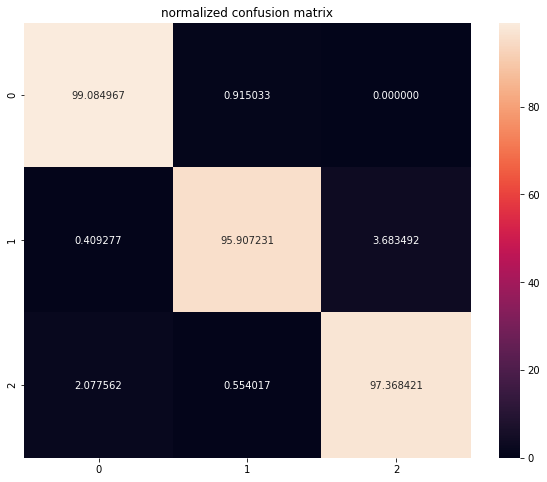

In [22]:
true_classes = []
pred_classes = []
for i in range(0, nbr_test_data//cfg.BATCH_SIZE +1):
    t_data, t_label = next(test_batch_generator)
    pred_labels = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
    pred_classes.extend(np.argmax(pred_labels, axis=1))
    true_classes.extend(np.argmax(t_label, axis=1))
#print (" true classes: " + str(len(true_classes))  + " pred classes: " + str(len(pred_classes)))
confusion_mtx = confusion_matrix(np.array(true_classes), np.array(pred_classes))
plt.figure(figsize=(10, 8))
plt.title("normalized confusion matrix")
norm_confusion_mtx = 100* confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_confusion_mtx, annot=True, fmt="f")
plt.show()

13) We can also show sample classification results

(128, 128, 3)


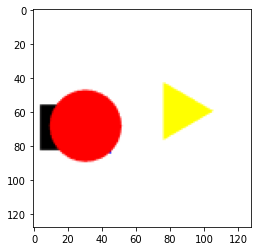

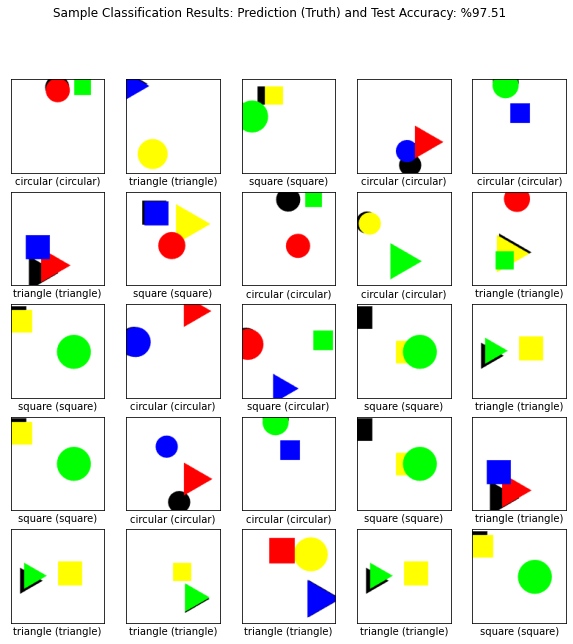

In [23]:
t_data, t_label = next(test_batch_generator)
print(t_data[0].shape)
plt.imshow(t_data[0])
pred_labels = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_classification_results(t_data, t_label, cfg.CLASSES, pred_labels, test_acc)

14) Finally, we can visualize CNN layer activations for a given sample input 

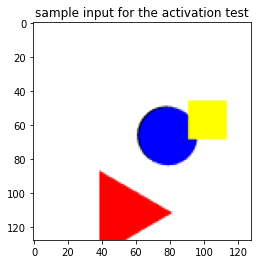

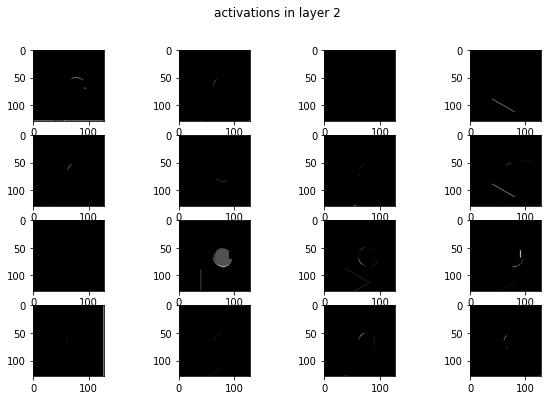

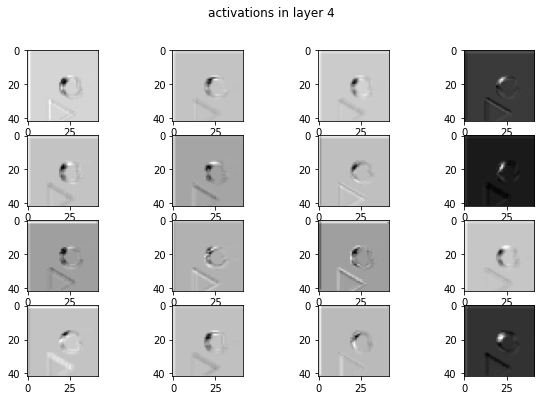

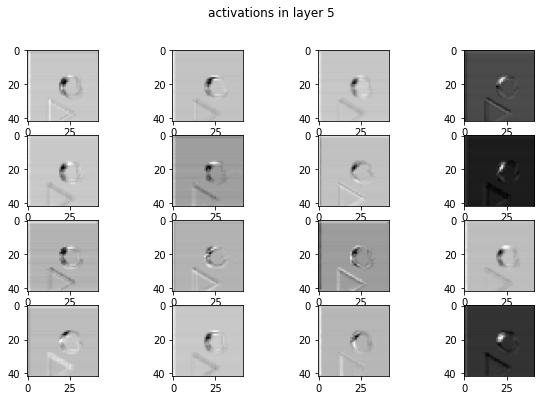

In [24]:
# Visualize CNN Layers
t_data, t_label = next(test_batch_generator)
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(t_data[10].reshape(1, cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL))

plt.imshow(t_data[10])
plt.title("sample input for the activation test")
modelObj.display_activation(activations, 4, 4, 1) # Displaying output of layer 2
modelObj.display_activation(activations, 4, 4, 3) # Displaying output of layer 4
modelObj.display_activation(activations, 4, 4, 4) # Displaying output of layer 5

## EXERCISES

Please do all exercises desribed below. Note that all your source code as well as the log folders must be provided as final results **before April 05, 2019.** 


#### Exercise 1)
Update the network architecture given in the function **create_model** of the class ClassifierDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. data augmentation, dropout) methods to increase the network accuracy. 

#### Exercise 3)
In the file **configClassifier.py**, there is a flag named as **cfg.fineGrained** which is set to **False**. This flag defines the classification granularity level. In the default setting, i.e. when it is **False**, there exist 3 class types: **Square**, **Triangle**, and **Circle**. In case of switching this flag to **True**, the class number goes to 15. Repeat previous exercises 1) and 2) after setting this flag to **True** and provide results. 

#### Hint:
All network resposes are stored in a **log folder** which is automatically created. To visualize these responses, we can use the tensorboard as follows:
- First make sure that there is a new folder created with **a date and time stamp** under folder **logs**
- Next, open a terminal and type 
    > tensorboard --logdir=./logs
- Finally, open a web browser and type 
    > http://localhost:6006
- You can have an overview of all accuracies on the tensorboard. For more information about tensorboard, please see https://www.tensorflow.org/guide/summaries_and_tensorboard

# The report!


### Name

Karl-Johan Djervbrant

### Introduction

This lab exercise was focused on getting a deeper understanding of CNNs with either Tensorflow or PyTorch. This lab was made in Tensorflow but PyTorch was explored a bit in the beginning.

### Answers to questions

#### *Q1: Update the network architecture given in the function create_model of the class ClassifierDNNModel*

A1: This stock model performed quite poorly with an test accuracy at $\approx50\%$. I first started with adding another Conv+Pool step and it increased the performance significantly to $\approx80\%$ in test accuracy, but I saw in the training data that it quickly began to overfit. After reading upon on Dropout and Batch Noramlization, I added both to the second and third conv+pool step and it increased the test accuracy to $94\%$. According to the [Tensorflow API Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), Dropout is a way of adding regularization by removing random units and the units which are not removed are scaled up by $(\frac{1}{1 - rate})$ where rate is the frequenzy which values are removed. The rate used in this case was 0.5. According to Goodfellow et al. in the book "Deep Learning", Batch Normalization is a way of reducing the complexity of a layer by reparameterizing it, it has also a regularization effect. As a test, yet another conv+pool layer was added and the test accuracy was again increased to `Test Loss:  0.1179 Test Accuracy:  0.9751` which I think is a really good result.

#### *Q2: Use different optimization (e.g. ADAM, SGD, etc) and regularization (e.g. data augmentation, dropout) methods to increase the network accuracy.*

### Summary